In [2]:
import networkx as nx
from scipy.optimize import linprog
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
def add_to_dict(dct, k, v):
    if k in dct:
        dct[k].append(v)
    else:
        dct[k] = [v]

class BiEdges():
    """Класс для хранения прямых и инвертированных ребер"""

    def __init__(self):
        self.direct = {}
        self.invert = {}


class AcyclicGraph():
    """Класс ациклического графа"""
    
    def __init__(self, file_name, W=None):
        self.G = nx.read_graphml(file_name)
        self.W = W
        self.bi_edges = self.build_bi_edges()
        self.pi = {node:float('inf') for node in self.G.nodes()}

    def build_bi_edges(self):       
        """Строит 2 списка ребер (прямых и инвертированных)"""
        res = BiEdges()
        for edge in self.G.edges():
            add_to_dict(res.direct, edge[0], edge[1])
            add_to_dict(res.invert, edge[1], edge[0])
        return res

    def __compare_sets(self, a, b):
        """Сравнение множеств"""
        return tuple(a) < tuple(b)

    def topological_sort(self):
        v_residual = set(self.G.nodes())
        sorted_pi = sorted([self.pi[node] for node in self.G.nodes()], reverse=True)
        for i in range(len(self.G.nodes())):
            vertex_to_update, min_set = None, sorted_pi
            for node in v_residual:
                if node in self.bi_edges.invert:
                    current_set = sorted(map(lambda x: self.pi[x], self.bi_edges.invert[node]), reverse=True)
                else:
                    current_set = set()
                if self.__compare_sets(current_set, min_set):
                    min_set = current_set
                    vertex_to_update = node
            self.pi[vertex_to_update] = i
            v_residual.remove(vertex_to_update)
    
    def greedy_layering(self):
        """Жадное присовение вершинам номер слоя"""
        v_residual = set(self.G.nodes())
        u = set()
        layers = [set()]
        while len(u) < len(self.G.nodes()):
            max_node = None
            max_pi = -1
            for node in v_residual:
                if node in self.bi_edges.direct:
                    is_subset = set(self.bi_edges.direct[node]) <= u
                else:
                    is_subset = True
                if is_subset and self.pi[node] > max_pi:
                    max_node = node
                    max_pi = self.pi[node]
            if max_node in self.bi_edges.direct:
                is_intersected = len(set(self.bi_edges.direct[max_node]).intersection(layers[-1])) > 0
            else:
                is_intersected = False
            if len(layers[-1]) >= self.W or is_intersected:
                layers.append(set())
            layers[-1].add(max_node)
            v_residual.remove(max_node)
            u.add(max_node)
        return layers

    def minimize_dummy_vertexes(self):
        """Минимизация dummy-вершин"""
        nodes = list(self.G.nodes())
        y_bounds = [(0, None) for _ in range(len(nodes))]
        node_to_id = {nodes[i]:i for i in range(len(nodes))}
        c = [0 for _ in range(len(nodes))]
        A = []
        for edge in self.G.edges():
            cur_bound = [0 for _ in range(len(nodes))]
            cur_bound[node_to_id[edge[0]]] = -1
            cur_bound[node_to_id[edge[1]]] = 1
            A.append(cur_bound)
            c[node_to_id[edge[0]]] += 1
            c[node_to_id[edge[1]]] -= 1

        b = [-1 for _ in range(len(A))]
        node_layers = linprog(c, A_ub=A, b_ub=b, bounds=y_bounds, method='revised simplex')['x']
        max_layer = int(max(node_layers))
        layers = [set() for i in range(max_layer+1)]
        for i in range(len(node_layers)):
            layers[int(node_layers[i])].add(nodes[i])
        return layers

    def __add_dummy_vertexes(self, layers, node_to_layer):
        """Добавление dummy-вершин в граф"""
        colors = {node:'#1f78b4' for node in self.G.nodes()}
        dummy_name = 'dummy_{0}'
        i = 0
        edges = list(self.G.edges())
        for edge in edges:
            if node_to_layer[edge[0]] - node_to_layer[edge[1]] > 1:
                prev_node = edge[0]
                self.G.remove_edge(*edge)
                for layer_num in range(node_to_layer[edge[0]]-1, node_to_layer[edge[1]], -1):
                    cur_dummy_name = dummy_name.format(i)
                    i += 1
                    layers[layer_num].add(cur_dummy_name)
                    self.G.add_node(cur_dummy_name, color='#FF0000')
                    self.G.add_edge(prev_node, cur_dummy_name)
                    prev_node = cur_dummy_name
                    colors[cur_dummy_name] = '#FF0000'
                self.G.add_edge(prev_node, edge[1])
        nx.set_node_attributes(self.G, colors, 'color')
        self.build_bi_edges()
        return layers

    def __insert_into_sorted(self, lst, elem):
        for i in range(len(lst)):
            if elem < lst[i]:
                return lst[:i] + [elem] + lst[i:]
        return lst + [elem]

    def minimize_intersections(self, layers):
        """Минимизация числа пересечений.
        Координата вершины - сред. арифм координат ее потомков"""
        node_to_layer = {}
        for i in range(len(layers)):
            for node in layers[i]:
                node_to_layer[node] = i
        layers = self.__add_dummy_vertexes(layers, node_to_layer)
        layer_0 = list(layers[0])
        coords = {layer_0[i]:(i, 0) for i in range(len(layer_0))}
        for i in range(1, len(layers)):
            layer = list(layers[i])
            point_dct = {}
            for j in range(len(layer)):
                x_coord = j
                if layer[j] in self.bi_edges.direct and len(self.bi_edges.direct[layer[j]]) > 0:
                    x_coord = sum(map(lambda x: coords[x][0], self.bi_edges.direct[layer[j]]))\
                     // len(self.bi_edges.direct[layer[j]])
                add_to_dict(point_dct, x_coord, layer[j])
            x_coords = sorted(point_dct.keys())
            point_num = 0
            while point_num < len(x_coords):
                x_coord = x_coords[point_num]
                if len(point_dct[x_coord]) > 1:
                    if x_coord + 1 in point_dct:
                        point_dct[x_coord + 1] = point_dct[x_coord][1:] + point_dct[x_coord + 1]
                    else:
                        point_dct[x_coord + 1] = point_dct[x_coord][1:]
                        x_coords = self.__insert_into_sorted(x_coords, x_coord + 1)
                point_dct[x_coord] = point_dct[x_coord][0]
                coords[point_dct[x_coord]] = (x_coord, i)
                point_num += 1
        return coords 

    def show(self):
        """"Изображение графа"""
        if self.W is not None:
            xticks_max = self.W
            self.topological_sort()
            layers = self.greedy_layering()
        else:
            layers = self.minimize_dummy_vertexes()
            xticks_max = len(max(layers, key=lambda x: len(x)))
        coords = self.minimize_intersections(layers) #минимизация числа пересечений с использованием эвристики

        nx.set_node_attributes(self.G, coords, 'pos')
        color_dct = nx.get_node_attributes(self.G, 'color')
        fig, ax = plt.subplots(figsize=(10,8))
        nx.draw_networkx(
            self.G,
            nx.get_node_attributes(self.G, 'pos'),
            with_labels=False,
            node_size=100,
            node_color=[color_dct[node] for node in self.G.nodes()],
            ax=ax
        )
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax.set_xticks(range(0, xticks_max+1, 2))
        plt.grid('on')
        plt.show()

## Во всех примерах синим цветом обозначены вершины графа, красным - dummy-вершины

### Визуализация графа на основе алгоритма Грэхема-Коффмана

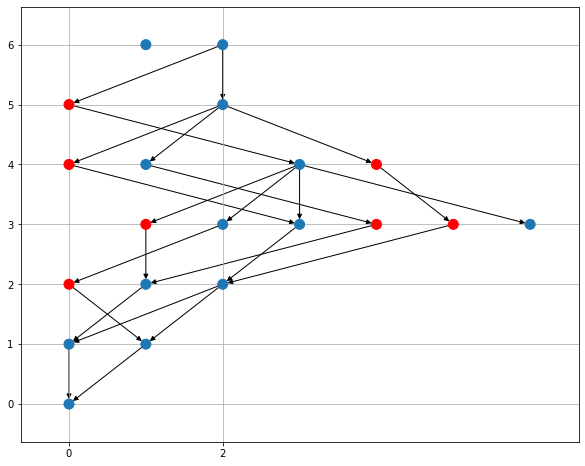

In [39]:
acyclic_graph = AcyclicGraph('small-test.xml', W=3)
acyclic_graph.show()

### Визуализация графа на основе алгоритма минимизации числа dummy-вершин

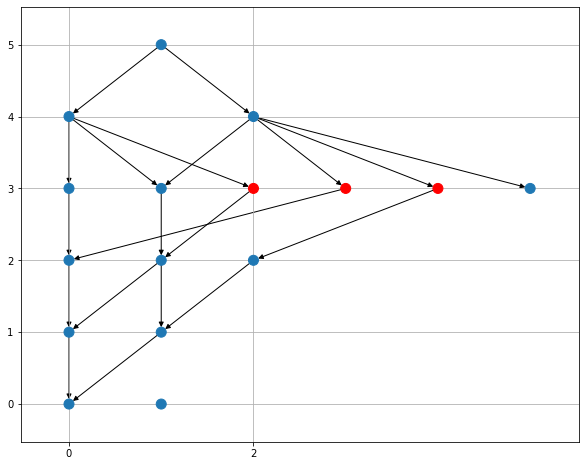

In [40]:
acyclic_graph = AcyclicGraph('small-test.xml')
acyclic_graph.show()